# Scenario 3

## 3.1 Base SIR model

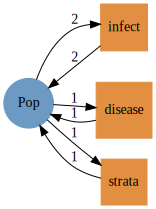

In [1]:
using AlgebraicPetri, AlgebraicPetri.TypedPetri
using Catlab.CategoricalAlgebra, Catlab.WiringDiagrams

const infectious_ontology = LabelledPetriNet(
  [:Pop],
  :infect=>((:Pop, :Pop)=>(:Pop, :Pop)),
  :disease=>(:Pop=>:Pop),
  :strata=>(:Pop=>:Pop)
)

Graph(infectious_ontology)

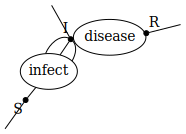

In [2]:
using Catlab.Programs, Catlab.Graphics

sir_uwd = @relation (S,I,R) where (S::Pop, I::Pop, R::Pop) begin
  infect(S,I,I,I) # inf
  disease(I,R) # rec
end

to_graphviz(sir_uwd, box_labels=:name, junction_labels=:variable)

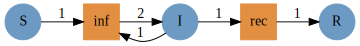

In [3]:
base_names = [:inf, :rec]
typed_sir = oapply_typed(infectious_ontology, sir_uwd, base_names)

Graph(dom(typed_sir))

## 3.2 Hospitalization and death

### SIRD

SIR model with death

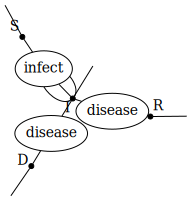

In [4]:
with_death_uwd = @relation (S,I,R,D) where (S::Pop, I::Pop, R::Pop, D::Pop) begin
  base(S,I,R)
  disease(I,D) # die
end

sird_uwd = ocompose(with_death_uwd, 1, sir_uwd)

to_graphviz(sird_uwd, box_labels=:name, junction_labels=:variable)

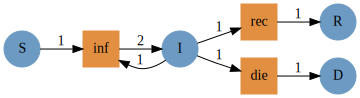

In [5]:
typed_sird = oapply_typed(infectious_ontology, sird_uwd, [base_names; :die])

Graph(dom(typed_sird))

In [6]:
write_json_acset(dom(typed_sird), "scenario3_sird.json")

257

### SIRH

SIR model with hospitalization

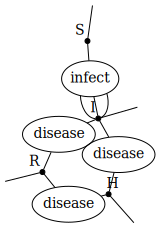

In [7]:
with_hospital_uwd = @relation (S,I,R,H) where (S::Pop, I::Pop, R::Pop, H::Pop) begin
  base(S,I,R)
  disease(I,H) # hosp
  disease(H,R) # hosp_rec
end

sirh_uwd = ocompose(with_hospital_uwd, 1, sir_uwd)

to_graphviz(sirh_uwd, box_labels=:name, junction_labels=:variable)

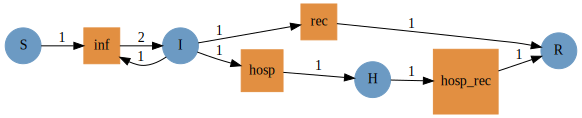

In [8]:
typed_sirh = oapply_typed(infectious_ontology, sirh_uwd,
  [base_names; [:hosp, :hosp_rec]])

Graph(dom(typed_sirh))

In [9]:
write_json_acset(dom(typed_sirh), "scenario3_sirh.json")

311

### SIRHD

SIR model with both hospitalization and death

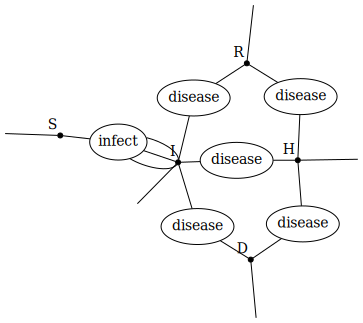

In [10]:
with_hospital_death_uwd = @relation (S,I,R,H,D) where (S::Pop, I::Pop, R::Pop, H::Pop, D::Pop) begin
  base(S,I,R,H)
  disease(I,D) # die
  disease(H,D) # hosp_die
end

sirhd_uwd = ocompose(with_hospital_death_uwd, 1, sirh_uwd)

to_graphviz(sirhd_uwd, box_labels=:name, junction_labels=:variable,
  edge_attrs=Dict(:len => "0.75"))

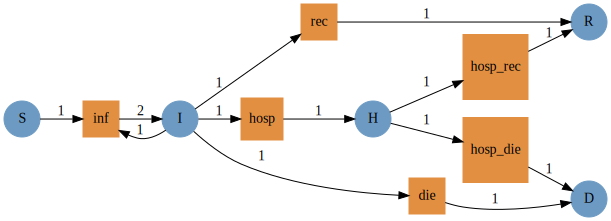

In [11]:
typed_sirhd = oapply_typed(infectious_ontology, sirhd_uwd,
  [base_names; [:hosp, :hosp_rec, :die, :hosp_die]])

Graph(dom(typed_sirhd))

In [12]:
write_json_acset(dom(typed_sirhd), "scenario3_sirhd.json")

426

## 3.3 Vaccination

SIRHD model with vaccination.

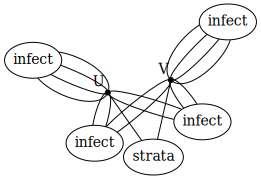

In [13]:
vaccination_uwd = @relation () where (U::Pop, V::Pop) begin
  strata(U,V) # vac
  infect(U,U,U,U)
  infect(U,V,U,V)
  infect(V,U,V,U)
  infect(V,V,V,V)
end

typed_vaccination = oapply_typed(infectious_ontology, vaccination_uwd,
  [:vac, :UU, :UV, :VU, :VV])

to_graphviz(vaccination_uwd, box_labels=:name, junction_labels=:variable,
  edge_attrs=Dict(:len => "1"), graph_attrs=Dict(:start => "2"))

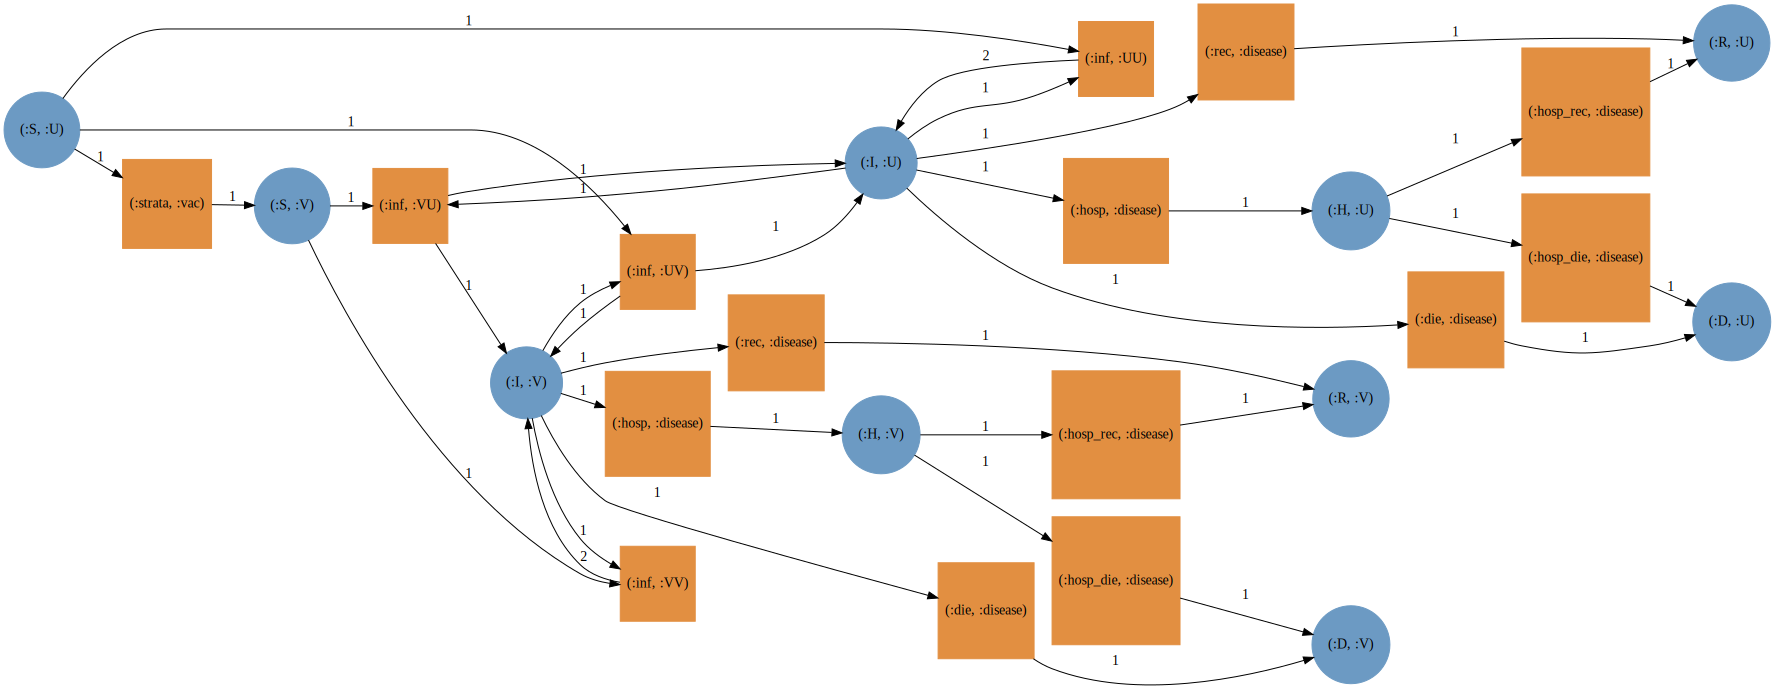

In [14]:
typed_sirhd_aug = add_reflexives(
  typed_sirhd, [[:strata],[],[],[],[]], infectious_ontology)

typed_vaccination_aug = add_reflexives(
  typed_vaccination,
  [[:disease], [:disease]],
  infectious_ontology
)

typed_sirhd_vac = typed_product(typed_sirhd_aug, typed_vaccination_aug)

Graph(dom(typed_sirhd_vac))

In [15]:
write_json_acset(dom(typed_sirhd_vac), "scenario3_sirhd_vac.json")

1268

## 3.4 Age stratification

SIRHD model with vaccination *and* age stratification.

In [16]:
for n in (2, 8)
  names = [Symbol("Age$i") for i in 1:n]
  typed_age = pairwise_id_typed_petri(infectious_ontology, :Pop, :infect, names)

  typed_age_aug = add_reflexives(
    typed_age,
    repeat([[:disease, :strata]], n),
    infectious_ontology
  )

  typed_sirhd_vac_age = typed_product(typed_sirhd_vac, typed_age_aug)
  net = dom(typed_sirhd_vac_age)
  
  write_json_acset(net, "scenario3_sirhd_vac_age$n.json")
  
  open("scenario3_sirhd_vac_age$n.svg", "w") do io
    show(io, MIME("image/svg+xml"), Graph(net))
  end
end